In [1]:
# Import necessary modules and set global constants and variables. 
      
import pandas as pd                 
import numpy as np                                       
from sklearn.cluster import KMeans
from scipy.ndimage.morphology import binary_fill_holes
import cv2                         # To read and manipulate images
import os                          # For filepath, directory handling
import sys                         # System-specific parameters and functions
import tqdm                        # Use smart progress meter
import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
%matplotlib inline

In [22]:
# Global constants.
DATA_DIR = "/home/javi/Escritorio/data/"
TRAIN_DIR = "supervised/stage1_train"
TEST_DIR = "unsupervised/stage1_test"
IMG_DIR_NAME = 'images'   # Folder name including the image
MASK_DIR_NAME = 'masks'   # Folder name including the masks
    

# Display working/train/test directories.
print('TRAIN_DIR = {}'.format(TRAIN_DIR))
print('TEST_DIR  = {}'.format(TEST_DIR))

TRAIN_DIR = supervised/stage1_train
TEST_DIR  = unsupervised/stage1_test


In [3]:
# Collection of methods for data operations. Implemented are functions to read  
# images/masks from files and to read basic properties of the train/test data sets.

def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None,space='bgr'):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    if space == 'hsv':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img

def read_train_data_properties(train_dir, img_dir_name, mask_dir_name):
    """Read basic properties of training images and masks"""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(train_dir))[1]):

        img_dir = os.path.join(train_dir, dir_name, img_dir_name)
        mask_dir = os.path.join(train_dir, dir_name, mask_dir_name)
        num_masks = len(next(os.walk(mask_dir))[2])
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        #mask_path = os.path.join(train_dir,dir_name,FULL_MASK_DIR_NAME,img_name_id+'_mask.png')
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], num_masks,
                    img_path, mask_dir])#,mask_path])

    train_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                            'img_ratio', 'num_channels', 
                                            'num_masks', 'image_path', 'mask_dir'])#,'mask_path'])
    return train_df


def read_test_data_properties(test_dir, img_dir_name):
    """Read basic properties of test images."""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(test_dir))[1]):

        img_dir = os.path.join(test_dir, dir_name, img_dir_name)
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], img_path])

    test_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                           'img_ratio', 'num_channels', 'image_path'])
    return test_df

def load_raw_data(image_size=(256, 256), space = 'bgr',load_mask=True):
    """Load raw data."""
    # Python lists to store the training images/masks and test images.
    x_train, y_train, x_test = [],[],[]

    # Read and resize train images/masks. 
    print('Loading and resizing train images and masks ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(train_df['image_path']), total=len(train_df)):
        img = read_image(train_df['image_path'].loc[i], target_size=image_size,space = space)
        if load_mask:
            mask = read_image(train_df['mask_path'].loc[i],
                              color_mode=cv2.IMREAD_GRAYSCALE,
                              target_size=image_size)
            #mask = read_mask(train_df['mask_dir'].loc[i], target_size=image_size)
            y_train.append(mask)
        x_train.append(img)
        
    # Read and resize test images. 
    print('Loading and resizing test images ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(test_df['image_path']), total=len(test_df)):
        img = read_image(test_df['image_path'].loc[i], target_size=image_size,space=space)
        x_test.append(img)

    # Transform lists into 4-dim numpy arrays.
    x_train = np.array(x_train)
    #if load_mask:
    y_train = np.array(y_train)
    #y_train = np.expand_dims(np.array(y_train), axis=4)
    x_test = np.array(x_test)
    print('Data loaded')
    if load_mask:
        return x_train, y_train, x_test
    else:
        return x_train, x_test

def get_domimant_colors(img, top_colors=1):
    """Return dominant image color"""
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

def cluster_images_by_hsv():
    """Clusterization based on hsv colors. Adds 'hsv_cluster' column to tables"""
    print('Loading data')
    x_train_hsv,x_test_hsv = load_raw_data(image_size=None,space='hsv',load_mask=False)
    x_hsv = np.concatenate([x_train_hsv,x_test_hsv])
    print('Calculating dominant hsv for each image')
    dominant_hsv = []
    for img in tqdm.tqdm(x_hsv):
        res1, res2 = get_domimant_colors(img,top_colors=1)
        dominant_hsv.append(res1.squeeze())
    print('Calculating clusters')
    kmeans = KMeans(n_clusters=3).fit(dominant_hsv)
    train_df['HSV_CLUSTER'] = kmeans.predict(dominant_hsv[:len(x_train_hsv)])
    test_df['HSV_CLUSTER'] = kmeans.predict(dominant_hsv[len(x_train_hsv):])
    print('Images clustered')
    return None

def plot_images(selected_images_df,images_rows=4,images_cols=8,plot_figsize=4):
    """Plot image_rows*image_cols of selected images. Used to visualy check clusterization"""
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(plot_figsize*images_cols,images_rows*plot_figsize))
    for row in range(images_rows):
        for col in range(images_cols):
            if (row*images_cols + col) < selected_images_df.shape[0]:
                image_path = selected_images_df['image_path'].iloc[row*images_cols + col]
            else:
                continue
            img = read_image(image_path)
            height, width, l = img.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(img)

In [4]:
# Basic properties of images/masks. 
train_df = read_train_data_properties(TRAIN_DIR, IMG_DIR_NAME, MASK_DIR_NAME)
test_df = read_test_data_properties(TEST_DIR, IMG_DIR_NAME)
cluster_images_by_hsv()
train_df.to_csv('./train_df.csv',index=False)
test_df.to_csv('./test_df.csv',index=False)

Loading data
Loading and resizing train images and masks ...


100%|██████████| 664/664 [00:02<00:00, 279.23it/s]

Loading and resizing test images ...



  0%|          | 1/729 [00:00<01:22,  8.86it/s]

Data loaded
Calculating dominant hsv for each image


100%|██████████| 729/729 [03:07<00:00,  3.89it/s]

Calculating clusters
Images clustered


In [5]:
# We don't need to compute everything (especially clusters) every time. simly load them
train_df = pd.read_csv('./train_df.csv')
test_df = pd.read_csv('./test_df.csv')

In [6]:
# we need to change filepath from my filesystem to kaggle filesystem
train_change_filepath = lambda x: TRAIN_DIR + '/{0}/images/{0}.png'.format(x.split('/')[-1][:-4])
test_change_filepath  = lambda x: TEST_DIR  + '/{0}/images/{0}.png'.format(x.split('/')[-1][:-4])
train_df.image_path = train_df.image_path.map(train_change_filepath)
train_df.drop(['mask_dir','mask_path'],inplace=True,axis = 1)
test_df.image_path = test_df.image_path.map(test_change_filepath)

ValueError: labels ['mask_path'] not contained in axis

# Train data

In [7]:
for idx in range(3):
    print("Images in cluster {}: {}".format(idx,train_df[train_df['HSV_CLUSTER'] == idx].shape[0]))

Images in cluster 0: 541
Images in cluster 1: 107
Images in cluster 2: 16


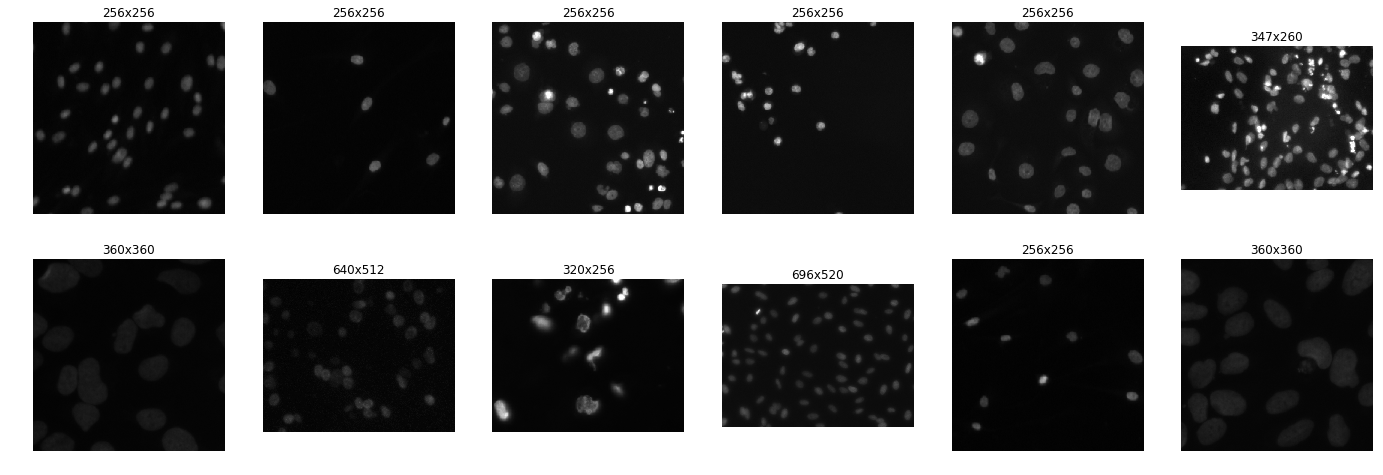

In [8]:
plot_images(train_df[train_df['HSV_CLUSTER'] == 0],2,6)

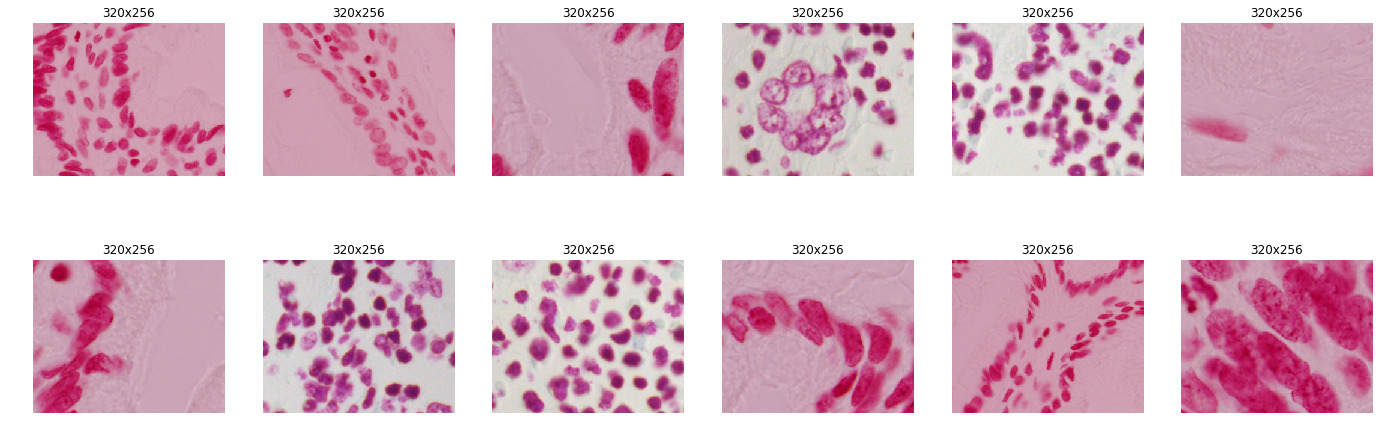

In [9]:
plot_images(train_df[train_df['HSV_CLUSTER'] == 1],2,6)

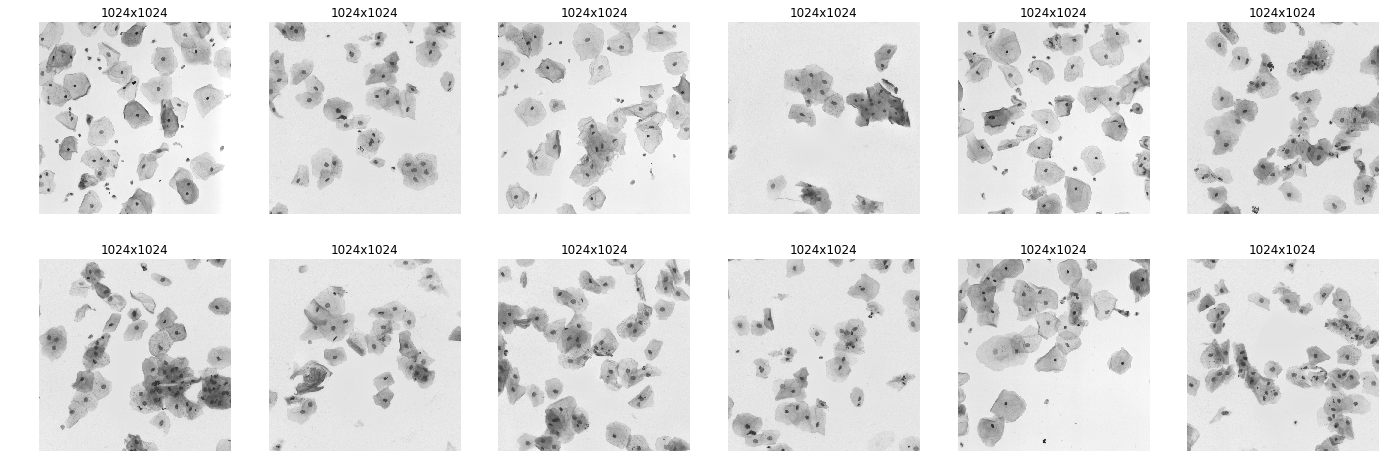

In [10]:
plot_images(train_df[train_df['HSV_CLUSTER'] == 2],2,6)

# Test data

In [11]:
for idx in range(3):
    print("Images in cluster {}: {}".format(idx,test_df[test_df['HSV_CLUSTER'] == idx].shape[0]))

Images in cluster 0: 53
Images in cluster 1: 4
Images in cluster 2: 8


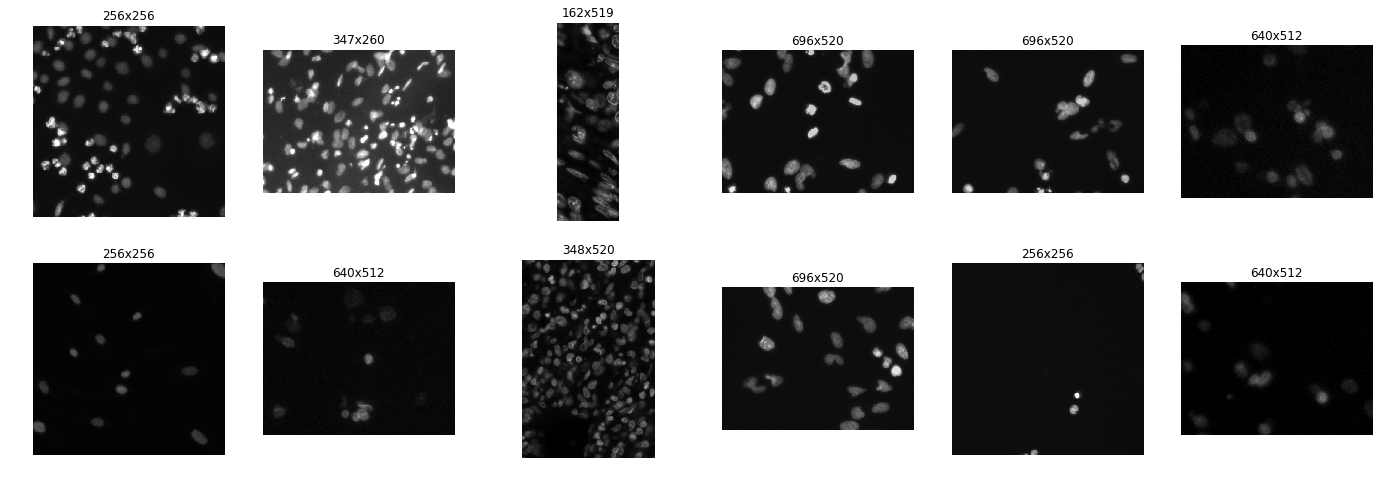

In [12]:
plot_images(test_df[test_df['HSV_CLUSTER'] == 0],2,6)

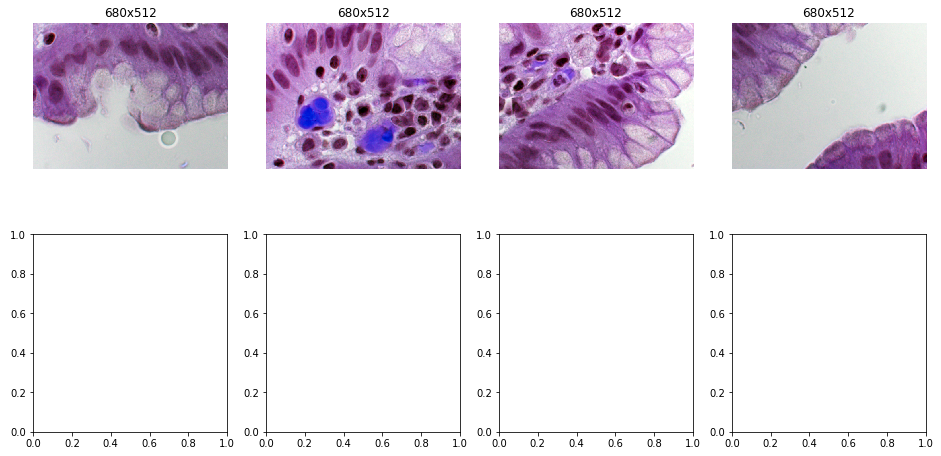

In [13]:
plot_images(test_df[test_df['HSV_CLUSTER'] == 1],2,4)

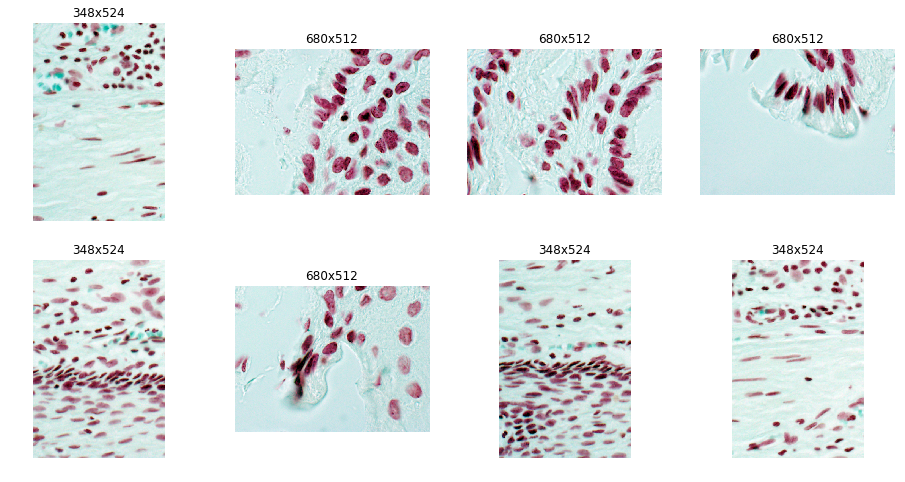

In [28]:
plot_images(test_df[test_df['HSV_CLUSTER'] == 2],2,4)

# Generate clusters directories (symlinks)

In [27]:
# Source ids
IDS_TRAIN_BLACK  = train_df[train_df['HSV_CLUSTER'] == 0]['img_id'].values.tolist()
IDS_TRAIN_PURPLE = train_df[train_df['HSV_CLUSTER'] == 1]['img_id'].values.tolist()
IDS_TRAIN_WHITE  = train_df[train_df['HSV_CLUSTER'] == 2]['img_id'].values.tolist()
IDS_TEST_BLACK   = test_df[test_df['HSV_CLUSTER'] == 0]['img_id'].values.tolist()
IDS_TEST_PURPLE  = test_df[test_df['HSV_CLUSTER'] == 1]['img_id'].values.tolist()
IDS_TEST_BLUE    = test_df[test_df['HSV_CLUSTER'] == 2]['img_id'].values.tolist()

# Destination
CLUSTER_DIR = DATA_DIR + "images"
DIR_TRAIN_BLACK  = CLUSTER_DIR + "/train_black"
DIR_TRAIN_PURPLE = CLUSTER_DIR + "/train_purple"
DIR_TRAIN_WHITE  = CLUSTER_DIR + "/train_white"
DIR_TEST_BLACK   = CLUSTER_DIR + "/test_black"
DIR_TEST_PURPLE  = CLUSTER_DIR + "/test_purple"
DIR_TEST_BLUE    = CLUSTER_DIR + "/test_blue"

if not os.path.exists(DIR_TRAIN_BLACK):  os.makedirs(DIR_TRAIN_BLACK)
if not os.path.exists(DIR_TRAIN_PURPLE): os.makedirs(DIR_TRAIN_PURPLE)
if not os.path.exists(DIR_TRAIN_WHITE):  os.makedirs(DIR_TRAIN_WHITE)
if not os.path.exists(DIR_TEST_BLACK):   os.makedirs(DIR_TEST_BLACK)
if not os.path.exists(DIR_TEST_PURPLE):  os.makedirs(DIR_TEST_PURPLE)
if not os.path.exists(DIR_TEST_BLUE):    os.makedirs(DIR_TEST_BLUE)

for id in IDS_TRAIN_BLACK:
    src = DATA_DIR + TRAIN_DIR + "/" + id + "/images/" + id + ".png"
    dst = DIR_TRAIN_BLACK + "/" + id + ".png"
    os.symlink(src, dst, target_is_directory=False)
    
for id in IDS_TRAIN_PURPLE:
    src = DATA_DIR + TRAIN_DIR + "/" + id + "/images/" + id + ".png"
    dst = DIR_TRAIN_PURPLE + "/" + id + ".png"
    os.symlink(src, dst, target_is_directory=False)
    
for id in IDS_TRAIN_WHITE:
    src = DATA_DIR + TRAIN_DIR + "/" + id + "/images/" + id + ".png"
    dst = DIR_TRAIN_WHITE + "/" + id + ".png"
    os.symlink(src, dst, target_is_directory=False)
    
for id in IDS_TEST_BLACK:
    src = DATA_DIR + TEST_DIR + "/" + id + "/images/" + id + ".png"
    dst = DIR_TEST_BLACK + "/" + id + ".png"
    os.symlink(src, dst, target_is_directory=False)
    
for id in IDS_TEST_PURPLE:
    src = DATA_DIR + TEST_DIR + "/" + id + "/images/" + id + ".png"
    dst = DIR_TEST_PURPLE + "/" + id + ".png"
    os.symlink(src, dst, target_is_directory=False)
    
for id in IDS_TEST_BLUE:
    src = DATA_DIR + TEST_DIR + "/" + id + "/images/" + id + ".png"
    dst = DIR_TEST_BLUE + "/" + id + ".png"
    os.symlink(src, dst, target_is_directory=False)
    
#for i, filename in enumerate(train_df['image_path']):